# Cliff Walking Q-Learning vs Sarsa

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

## Cliff GridWorld 환경 
- environment class 정의

In [3]:
class GridWorld:
    terrain_color = dict(normal=[128, 128, 128],
                         objective=[255, 0, 0],
                         cliff=[0, 0, 255],
                         player=[255, 255, 0])
        
    def __init__(self):
        self.grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
        self.grid[-1, 0] = self.terrain_color['player']
        self.grid[-1, 1:11] = self.terrain_color['cliff']
        self.grid[-1, -1] = self.terrain_color['objective']
    
        self._draw_grid()
            
    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 4))
        self.ax.grid(which='minor') 
        for idx in range(12 * 4):
            self.ax.text(*self._id_to_position(idx)[::-1], 
                         str(idx)+'/'+str(self._id_to_position(idx)),
                        horizontalalignment="center") 
         
        self.ax.imshow(self.grid.astype(np.uint8), cmap='terrain')        
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)

    def show_grid(self, Q):
        self.fig, self.ax = plt.subplots(figsize=(16, 8))
        self.ax.grid(which='minor') 
        for idx in range(12 * 4):
            self.ax.text(*self._id_to_position(idx)[::-1],                    
                "\n".join("{:.2f}".format(k) for k in Q[idx]),
                        horizontalalignment="center", 
                        verticalalignment="center", fontsize=12) 
         
        self.ax.imshow(self.grid.astype(np.uint8), cmap='terrain')        
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)
        self.ax.set_title("up, down, right, left")
    
        
    def _id_to_position(self, idx):
        return (idx // 12), (idx % 12)  # (y, x)
    
    def reset(self):
        self.player = (3, 0)        
        return self._position_to_id(self.player)
    
    def _position_to_id(self, pos):
        ''' x, y 좌표를 unique ID 로 mapping --> y * 12 + x 
            pos : (y, x) 
        '''
        return pos[0] * 12 + pos[1]  

    def step(self, action):
        # UP = 0, DOWN = 1, RIGHT = 2, LEFT = 3
        # player 좌표: (y, x)
        if action == 0 and self.player[0] > 0:
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < 3:
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < 11:
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:
            self.player = (self.player[0], self.player[1] - 1)
            
        # Rules
        if all(self.grid[self.player] == self.terrain_color['cliff']):
            reward = -100
            done = True
        elif all(self.grid[self.player] == self.terrain_color['objective']):
            reward = 0
            done = True
        else:
            reward = -1
            done = False
            
        return self._position_to_id(self.player), reward, done

- environment 생성

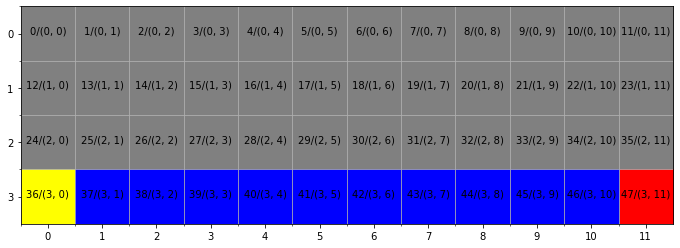

In [4]:
env = GridWorld()
env

- action space 정의

In [5]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
actions = ['UP', 'DOWN', 'RIGHT', 'LEFT']

- state 수, action 수 계산

In [6]:
num_states = 4 * 12
num_actions = 4

- 정책 정의

In [7]:
# epsilon-greedy policy
def pi(Q, state, e=0.1):
    if np.random.random() < e:
        return np.random.choice(4)
    else:
        return np.argmax(Q[state])

- Q-Learning, Sarsa 알고리즘 정의

In [8]:
num_episodes = 500
gamma = 0.9
alpha = 0.5
epsilon = 0.1

def Q_Learning():
    Q = defaultdict(lambda: np.zeros(num_actions))
    
    for episode in range(num_episodes):   
        s = env.reset()
        done = False  
        while not done:
            # Choose action
            a = pi(Q, s, epsilon)
            s_, r, done = env.step(a)
            Q[s][a] += alpha * (r + gamma * np.max(Q[s_]) - Q[s][a])
            s = s_
            
    return Q
            
def Sarsa():
    Q = defaultdict(lambda: np.zeros(num_actions))
    
    for episode in range(num_episodes):   
        s = env.reset()
        done = False  
        # Choose action
        a = pi(Q, s, epsilon)
        while not done:
            s_, r, done = env.step(a)
            # Choose next action
            a_ = pi(Q, s_, epsilon)      
            Q[s][a] += alpha * (r + gamma * Q[s_][a_] - Q[s][a])
            s = s_
            a = a_
            
    return Q

- Q-Learning state-action value table 시각화

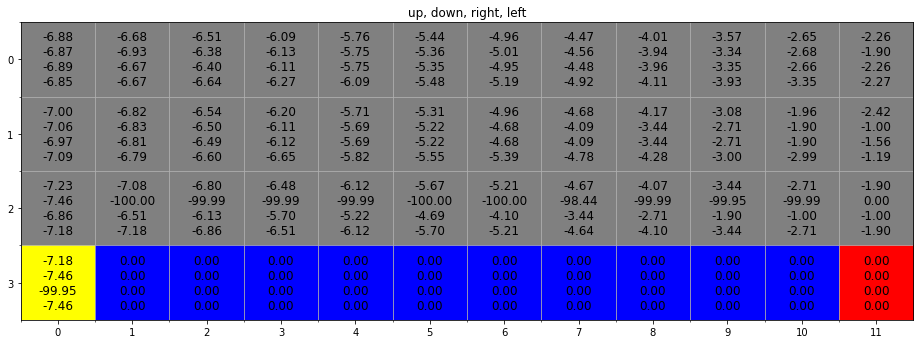

In [9]:
Q = Q_Learning()

env.show_grid(Q)

- Sarsa state-action value table 시각화

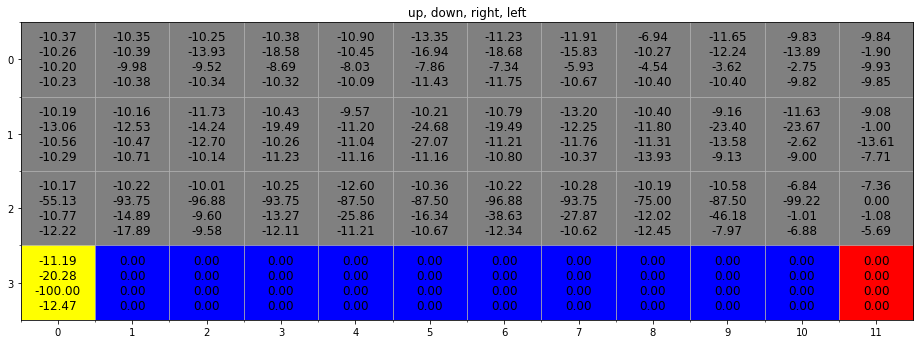

In [10]:
Q = Sarsa()

env.show_grid(Q)